In [1]:
import os
import pandas as pd
import re
from collections import Counter
import html
import matplotlib.pyplot as plt
import seaborn as sns
from metadata.metadata import ACL_metadata
from collections import defaultdict
from itertools import chain
import numpy as np
from scipy import stats
%matplotlib inline
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

def clamp(x): 
    return max(0, min(x, 255))
def get_htmlcol(c):
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(c[0]), clamp(c[1]), clamp(c[2]))

colors = [get_htmlcol(tableau20[2]),get_htmlcol(tableau20[0]),get_htmlcol(tableau20[4])]

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)


In [2]:
acl = ACL_metadata()
auths = acl.auths
known = acl.known
known_f = acl.known_f
known_m = acl.known_m
unique_ids = acl.ids
new_unknown = acl.unk
df = acl.meta_df

Remember to use acl.modeling_files and modeling_df for topic modeling


In [3]:
print("{0} papers and {1} unique authors".format(df.shape[0],len(acl.auths)))
print("Average papers per authors {0:.2f}".format(df.shape[0]/len(acl.auths)))

23766 papers and 18128 unique authors
Average papers per authors 1.31


## Single authored papers

In [10]:
from collections import defaultdict
from itertools import chain
females = defaultdict(list)
males = defaultdict(list)
total_f = 0
total_m = 0
s_f = 0
s_t = 0
s_m = 0
t_p=0
for i in range(1964,2015):
    year = df[df["year"] == i]
    papers = year["authors"]
    for auths in papers:
        t_p+=1
        if(len(auths)==1):
            s_t+=1
            if(auths[0] in known_f):
                s_f += 1
            elif(auths[0] in known_m):
                s_m += 1
        for a in auths:
            if a in known_f:
                females[a].append(i)
                total_f+=1
            elif a in known_m:
                males[a].append(i)
                total_m+=1
    
print("Females represent {} of single author papers".format(s_f/s_t))
print("Males represent {} of single author papers".format(s_m/s_t))
print("Females write {} of their papers as single author papers".format(s_f/total_f))
print("Males write {} of their papers as single author papers".format(s_m/total_m))

Females represent 0.23750681446483737 of single author papers
Males represent 0.7539523896056697 of single author papers
Females write 0.08297885848517554 of their papers as single author papers
Males write 0.09374576347778933 of their papers as single author papers


## Mean number of collaborators

In [23]:
ranges = list(map(lambda x:list(x),[range(1,5), range(6,10), range(10,20), range(20,50), range(50,100),range(100,150)]))

n_colab_f = defaultdict(set)
n_papers_f=defaultdict(int)
for i in range(1964,2015):
    year = df[df["year"] == i]
    papers = year["authors"]
    for auths in papers:
        n = len(auths)
        for a in auths:
            if a in known_f:
                n_papers_f[a]+=1
                for a2 in auths:
                    if a!=a2:
                        n_colab_f[a].add(a2)
    
print("Mean number of collabs for females, overall:{}".format(
    np.mean(list(map(lambda x: len(x[1]), n_colab_f.items())))))
print("Mean number of papers for females, overall:{} \n".format(
    np.mean(list(map(lambda x: x[1], n_papers_f.items())))))
# numbers of collaborators in each range for females
fm=[]

for ix,i in enumerate(ranges):
    n = 1e-6
    n_f=0
    for a, f in n_colab_f.items():
        if n_papers_f[a]>=i[0] and n_papers_f[a]<=i[-1]:
            n+=1
            n_f += len(n_colab_f[a])
    s_f=n_f/n
    fm.append(s_f)
    
n_colab_f = defaultdict(set)
n_papers_f=defaultdict(int)
for i in range(1964,2015):
    year = df[df["year"] == i]
    papers = year["authors"]
    for auths in papers:
        n = len(auths)
        for a in auths:
            if a in known_m:
                n_papers_f[a]+=1
                for a2 in auths:
                    if a!=a2:
                        n_colab_f[a].add(a2)
    
print("Mean number of collabs for males, overall:{}".format(
    np.mean(list(map(lambda x: len(x[1]), n_colab_f.items())))))
print("Mean number of papers for males, overall:{}".format(
    np.mean(list(map(lambda x: x[1], n_papers_f.items())))))

mm=[]
# numbers of collaborators in each range for males
for ix,i in enumerate(ranges):
    n = 1e-6
    n_f=0
    for a, f in n_colab_f.items():
        if n_papers_f[a]>=i[0] and n_papers_f[a]<=i[-1]:
            n += 1
            n_f += len(n_colab_f[a])
    s_f=n_f/n
    mm.append(s_f)

Mean number of collabs for females, overall:6.328460877042132
Mean number of papers for females, overall:3.2237003683995087 

Mean number of collabs for males, overall:6.657892458221491
Mean number of papers for males, overall:3.6101059494702525


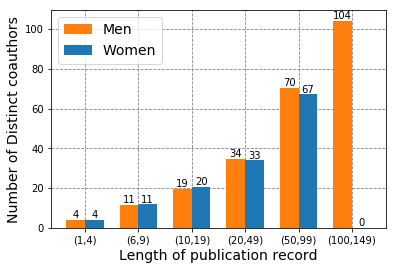

In [12]:
import numpy as np
import matplotlib.pyplot as plt

N = len(mm)
men_means = mm


ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color=tableau20[2])

women_means = fm
rects2 = ax.bar(ind + width, women_means, width, color=tableau20[0])

# add some text for labels, title and axes t,fontsize=14icks
ax.set_ylabel('Number of Distinct coauthors',fontsize=14)
ax.set_xlabel('Length of publication record',fontsize=14)
ax.set_xticks(ind + width / 2)

a= list(map(lambda x: "({},{})".format(x[0],x[-1]), ranges))
ax.set_xticklabels((a))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'),fontsize=14)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
plt.savefig("plots/dist_coauth.pdf")

## Number of papers, most prolific and mean

In [25]:
papers_per_active_year = []
for f, years in females.items():
    c = Counter(years)
    counts = list(map(lambda x: x[1], list(c.items())))
    avg = np.mean(counts)
    papers_per_active_year.append(avg)

Mean number of papers, females 3.2237003683995087
Mean number of papers, males 3.6075970003260514
T-test, mean number of papers
-3.25087292987 0.000576366013189


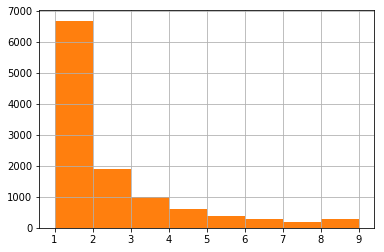

In [30]:
n_paperss = []
for a, y in females.items():
    n_paperss.append(len(y))
print("Mean number of papers, females {}".format(np.mean(n_paperss)))
pd.Series(n_paperss).hist(bins=(np.arange(1,10,1)))
n_paperss2 = []
for a, y in males.items():
    n_paperss2.append(len(y))
print("Mean number of papers, males {}".format(np.mean(n_paperss2)))
pd.Series(n_paperss2).hist(bins=(np.arange(1,10,1)))

Ttest_indResult = stats.ttest_ind(n_paperss, n_paperss2)
real_t_score=Ttest_indResult.statistic
real_pvalue=Ttest_indResult.pvalue/2
print("T-test, mean number of papers")
print(real_t_score, real_pvalue)

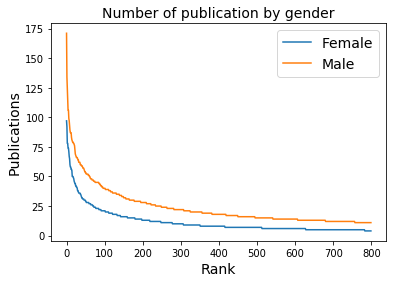

In [33]:
n_papers_f = sorted(n_paperss, reverse=True)
n_papers_m = sorted(n_paperss2, reverse=True)
n_limit = 800
plt.plot(list(range(n_limit)),n_papers_f[:n_limit],color=tableau20[0],label="Female")
plt.plot(list(range(n_limit)),n_papers_m[:n_limit],color=tableau20[2],label="Male")
plt.legend(fontsize=14)
plt.ylabel("Publications",fontsize=14)
plt.xlabel("Rank",fontsize=14)
plt.title("Number of publication by gender",fontsize=14)
plt.savefig("plots/Rankings.pdf")

## Papers per active year

In [34]:
papers_per_active_year = []
for f, years in females.items():
    c = Counter(years)
    counts = list(map(lambda x: x[1], list(c.items())))
    avg = np.mean(counts)
    papers_per_active_year.append(avg)
print("Mean number of active years, females: {}".format(np.mean(papers_per_active_year)))   
papers_per_active_year2 = []
for f, years in males.items():
    c = Counter(years)
    counts = list(map(lambda x: x[1], list(c.items())))
    avg = np.mean(counts)
    papers_per_active_year2.append(avg)
print("Mean number of active years, males: {}".format(np.mean(papers_per_active_year2))) 
Ttest_indResult = stats.ttest_ind(papers_per_active_year, papers_per_active_year2)
real_t_score=Ttest_indResult.statistic
real_pvalue=Ttest_indResult.pvalue/2
print("T-test, mean number of papers per active year")
print(real_t_score, real_pvalue)

Mean number of active years, females: 1.209242490253658
Mean number of active years, males: 1.2373167578481712
T-test, mean number of active years
-3.30551829741 0.000474977103276


## Number of active years in the field (longevity)

Females have been in the field for 2.6123618501842 years
Males have been in the field for 2.941392239973916 years
T-test, mean number of active years
3.51094086716 0.000223835083928


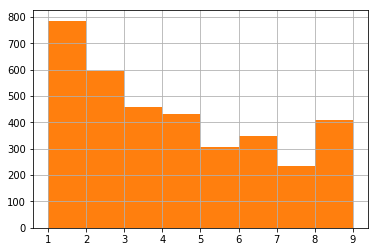

In [40]:
active_years = []
for a, y in females.items():
  
    active_years.append(y[-1]-y[0])
print("Females have been in the field for {} years".format(np.mean(active_years)))
pd.Series(active_years).hist(bins=(np.arange(1,10,1)))

active_years2 = []
for a, y in males.items():
    active_years2.append(y[-1]-y[0])
print("Males have been in the field for {} years".format(np.mean(active_years2)))
pd.Series(active_years2).hist(bins=(np.arange(1,10,1)))


Ttest_indResult = stats.ttest_ind(active_years2, active_years)
real_t_score=Ttest_indResult.statistic
real_pvalue=Ttest_indResult.pvalue/2
print("T-test, mean number of active years")
print(real_t_score, real_pvalue)

In [464]:
fem_last = []
for i in range(1974,2015):
    year = df[df["year"] == i]
    papers = year["authors"]
    for auths in papers:
        if len(auths) < 3:
            continue
        if auths[-1] in known_f:
            if auths[-1] in females:
                if females[auths[-1]] != None and len(females[auths[-1]]) > 2:
                    first = females[auths[-1]][0]
                    if first != i:
                        fem_last.append(i - females[auths[-1]][0] + 1)
                        females[auths[-1]] = None

In [465]:
np.mean(fem_last)

7.2406143344709895

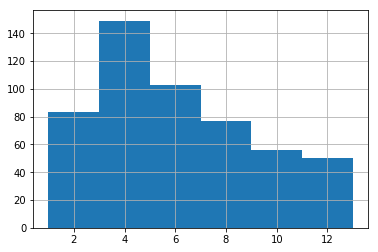

In [466]:
pd.Series(fem_last).hist(bins=np.arange(1,15,2))

In [467]:
men_last = []
for i in range(1974,2015):
    year = df[df["year"] == i]
    papers = year["authors"]
    for auths in papers:
        if len(auths) < 3:
            continue
        if auths[-1] in known_m:
            if auths[-1] in males:
                if males[auths[-1]] != None and len(males[auths[-1]]) > 2:
                    first = males[auths[-1]][0]
                    if first != i:
                        men_last.append(i - males[auths[-1]][0] + 1)
                        males[auths[-1]] = None

In [468]:
Ttest_indResult = stats.ttest_ind(men_last, fem_last)
real_t_score=Ttest_indResult.statistic
real_pvalue=Ttest_indResult.pvalue/2
print(real_t_score, real_pvalue)

2.32935896512 0.0099658065313


In [469]:
np.mean(men_last)

7.9146110056926

In [470]:
from collections import defaultdict
from itertools import chain
girls = defaultdict(set)
boys = defaultdict(set)
last_publ = defaultdict(int)
first_publ = defaultdict(int)
for i in range(1974,2015):
    year = df[df["year"] == i]
    auths = set(chain.from_iterable(year["authors"]))
    for a in auths:
        if first_publ[a] == 0:
            first_publ[a] = i
            last_publ[a] = i
            continue
       
#         if last_publ[a]-first_publ[a] > 5:
#             last_publ[a]=i
#             first_publ[a]=i
#             continue
        if last_publ[a] - first_publ[a] < 4:
            last_publ[a] = i
            continue
        last_publ[a] = i
       
        if a in known_f: 
            girls[i].add(a)
        elif a in known_m: 
            boys[i].add(a)
m = []
f = []
for i in range(1990,2015):
    m.append(len(boys[i]))
    f.append(len(girls[i]))
    

In [471]:
girls = defaultdict(set)
boys = defaultdict(set)
last_publ = defaultdict(int)
first_publ = defaultdict(int)
for i in range(1964,2015):
    year = df[df["year"] == i]
    auths = set(chain.from_iterable(year["authors"]))
    for a in auths:
        if first_publ[a] == 0:
            first_publ[a] = i
            last_publ[a] = i
            continue
       
#         if last_publ[a]-first_publ[a] >10:
#             last_publ[a]=i
#             first_publ[a]=i
#             continue
        if last_publ[a] - first_publ[a] < 9:
            last_publ[a] = i
            continue
        last_publ[a] = i
       
        if a in known_f: 
            girls[i].add(a)
        elif a in known_m: 
            boys[i].add(a)
m2 = []
f2 = []
for i in range(1990,2015):
    m2.append(len(boys[i]))
    f2.append(len(girls[i]))

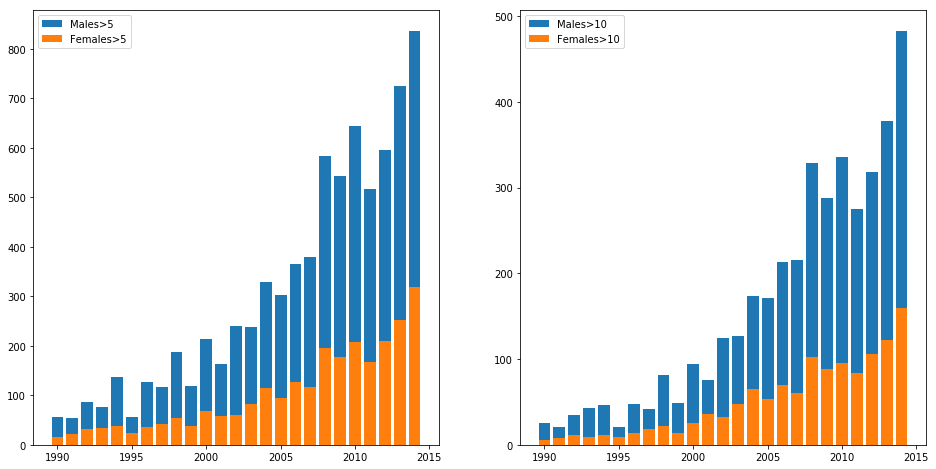

In [472]:
fix, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].bar(range(1990,2015),m,label="Males>5")
ax[0].bar(range(1990,2015),f,label="Females>5")
ax[1].bar(range(1990,2015),m2,label="Males>10")
ax[1].bar(range(1990,2015),f2,label="Females>10")
ax[0].legend()
ax[1].legend()
plt.savefig("plots/Active5-10years.pdf")
plt.show()

In [473]:
diff

array([  2,   0,   0,   1,   0,   2,   0,  -1,  -1,   4,  12,   8,  15,
        14,   1,   2,   8,   6,  24,  11,  23,  12,  32,  26,  39,  27,
        33,  36,  50,  32,  57,  42,  48,  57, 117])

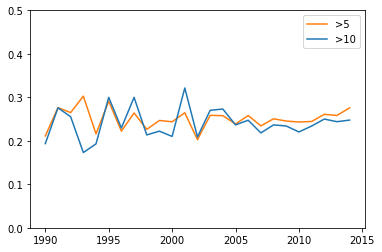

In [474]:
p = np.array(f)/ (np.array(f) +np.array(m))
plt.plot(range(1990,2015), p, label=">5", color = tableau20[2])
p = np.array(f2)/ (np.array(f2) +np.array(m2))
plt.plot(range(1990,2015), p, label=">10", color=tableau20[0])
plt.ylim(0,0.5)
plt.legend()

## Cohort Analysis

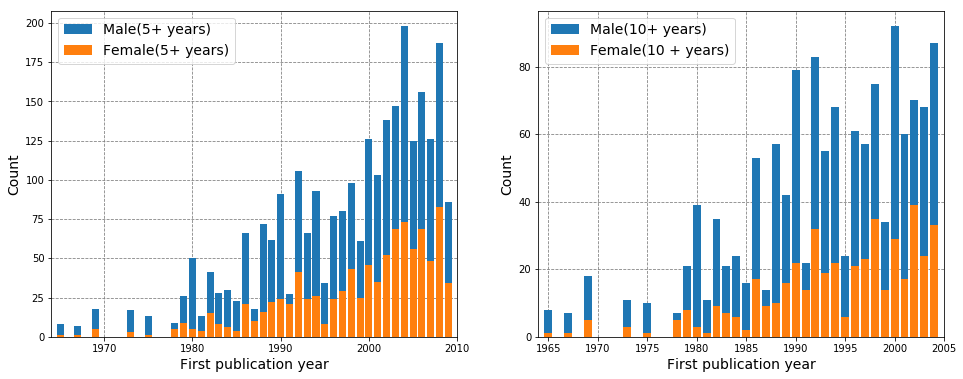

In [41]:
females = defaultdict(list)
males = defaultdict(list)
for i in range(1964,2015):
    year = df[df["year"] == i]
    auths = set(chain.from_iterable(year["authors"]))
    for a in auths:
        if a in known_f:
                females[a].append(i)
        elif a in known_m:
            males[a].append(i)
# for i in range(1964,2015):
#     year = df[df["year"] == i]
#     papers = year["authors"]
#     for auths in papers:
#         for a in auths:
#             if a in known_f:
#                 females[a].append(i)
#             elif a in known_m:
#                 males[a].append(i)

yrs_f = [0] * len(range(1964,2010))
for f, years in females.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=5):
            yrs_f[years[0]-1964] += 1

yrs_m = [0] * len(range(1964,2010))
for f, years in males.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=5):
            yrs_m[years[0]-1964] += 1
    
fix, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].bar(range(1964,2010),yrs_m,label="Male(5+ years)")
ax[0].bar(range(1964,2010),yrs_f,label="Female(5+ years)")

yrs_f2 = [0] * len(range(1964,2010))
for f, years in females.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=10):
            yrs_f2[years[0]-1964] += 1

yrs_m2 = [0] * len(range(1964,2010))
for f, years in males.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=10):
            yrs_m2[years[0]-1964] += 1
    


ax[1].bar(range(1964,2010),yrs_m2,label="Male(10+ years)",)
ax[1].bar(range(1964,2010),yrs_f2,label="Female(10 + years)")

ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[0].set_xlim(1964,2010)
ax[1].set_xlim(1964,2005)
ax[0].set_xlabel("First publication year",fontsize=14)
ax[0].set_ylabel("Count",fontsize=14)
ax[1].set_xlabel("First publication year",fontsize=14)
ax[1].set_ylabel("Count",fontsize=14)
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')

plt.savefig("plots/Cohort-analysis.pdf")

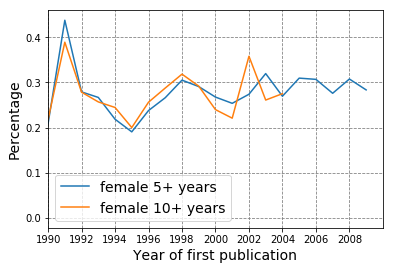

In [47]:
perc = np.array(yrs_f)/(np.array(yrs_f)+np.array(yrs_m)+np.array([1e-6]*len(yrs_f)))
plt.plot(range(1964,2010,1), perc,color=tableau20[0],label="female 5+ years")
perc = np.array(yrs_f2)/(np.array(yrs_f2)+np.array(yrs_m2)+np.array([1e-6]*len(yrs_f2)))
plt.plot(range(1964,2005,1), perc[:-5],color=tableau20[2],label="female 10+ years")
plt.legend(fontsize=14)
plt.ylabel("Percentage",fontsize=14)
plt.xlabel("Year of first publication",fontsize=14)
plt.xticks(np.arange(110,2010,2))
ax=plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.xlim(1990,2010)
plt.savefig("plots/Cohortpercentage.pdf")

In [48]:
for i in range(1964,2015):
    year = df[df["year"] == i]
    papers = year["authors"]
    for auths in papers:
        for a in auths:
            if a in known_f:
                females[a].append(i)
            elif a in known_m:
                males[a].append(i)

In [49]:
fem_excess = []
for f, years in females.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=10):
            print(years)
            c = 1
            for y in years[1:]:
                if y - years[0] <=10:
                    c+=1
            fem_excess.append(c)
            print(fem_excess)

[1965, 1967, 1979, 1981, 1982, 1983, 1965, 1967, 1979, 1979, 1981, 1982, 1983]
[4]
[1967, 1979, 1982, 1997, 1967, 1979, 1979, 1982, 1997]
[4, 2]
[1969, 1980, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1990, 1992, 1993, 1995, 1998, 2000, 2001, 2004, 2006, 2007, 2008, 1969, 1969, 1980, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1990, 1992, 1992, 1993, 1995, 1998, 2000, 2000, 2001, 2004, 2004, 2006, 2007, 2008]
[4, 2, 3]
[1969, 1986, 1969, 1986]
[4, 2, 3, 2]
[1969, 1979, 1982, 1983, 1991, 1992, 1993, 1969, 1979, 1982, 1983, 1991, 1991, 1991, 1992, 1992, 1993]
[4, 2, 3, 2, 4]
[1969, 1984, 1985, 1986, 1990, 1992, 1994, 1995, 1996, 1997, 1998, 2000, 2005, 2006, 2007, 2012, 1969, 1969, 1984, 1985, 1986, 1990, 1992, 1994, 1994, 1995, 1996, 1996, 1997, 1998, 2000, 2000, 2005, 2006, 2007, 2007, 2012]
[4, 2, 3, 2, 4, 3]
[1969, 1979, 1986, 1969, 1979, 1979, 1986, 1986]
[4, 2, 3, 2, 4, 3, 5]
[1973, 1982, 1983, 1986, 1987, 1988, 2001, 2011, 1973, 1982, 1983, 1986, 1987, 1988, 2001, 2011]
[4, 2, 3, 2, 

In [50]:
male_excess = []
for f, years in males.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=10):
            c = 1
            for y in years[1:]:
                if y -years[0] <=10:
                    c+=1
            male_excess.append(c)

In [51]:
np.mean(np.array(fem_excess))

12.460352422907489

In [52]:
np.mean(np.array(male_excess))

12.773513920240783

In [53]:
Ttest_indResult = stats.ttest_ind(male_excess, fem_excess)
real_t_score=Ttest_indResult.statistic
real_pvalue=Ttest_indResult.pvalue/2
print(real_t_score, real_pvalue)

0.544091733366 0.293223227179


/home/ramona/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


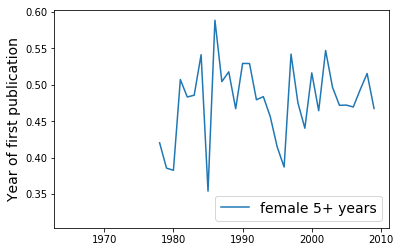

In [54]:
excess_f = np.array([0] * len(range(1964,2010)))
n = np.array([1e-6] * len(range(1964,2010)))
for f, years in females.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=5):
            c = 1
            for y in years[1:]:
                if y -years[0] <=5:
                    c+=1
            excess_f[years[0]-1964] += c
            n[years[0]-1964]+=1
excess_f = excess_f/n
    
excess_m = np.array([0] * len(range(1964,2010)))
n = np.array([1e-6] * len(range(1964,2010)))
for f, years in males.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=5):
            c = 1
            for y in years[1:]:
                if y -years[0] <=5:
                    c+=1
            excess_m[years[0]-1964] += c
            n[years[0]-1964]+=1
excess_m = excess_m/n
            
excess_f2 = [0] * len(range(1964,2010))
for f, years in females.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=10):
            c = 1
            for y in years[1:]:
                if y -years[-1] <=10:
                    c+=1
            excess_f2[years[0]-1964] += c
excess_m2 = [0] * len(range(1964,2010))
for f, years in males.items():
    if len(years) >= 2:
        if(years[-1]-years[0]>=10):
            c = 1
            for y in years[1:]:
                if y -years[-1] <=10:
                    c+=1
            excess_m2[years[0]-1964] += c
perc = np.array(excess_f)/ (np.array(excess_m)+np.array(excess_f))
plt.plot(range(1964,2010), perc,color=tableau20[0],label="female 5+ years")
# perc = np.array(excess_m2) - np.array(excess_f2)
# plt.plot(range(1964,2005), perc[:-5],color=tableau20[2],label="female 10+ years")
plt.legend(fontsize=14)
plt.ylabel("Percentage",fontsize=14)
plt.ylabel("Year of first publication",fontsize=14)
plt.savefig("plots/CohortExcess.pdf")

## Cohort dropout

In [105]:
females = defaultdict(list)
males = defaultdict(list)
year_range = [1964, 2015]
for i in range(1964,2015):
    year = df[df["year"] == i]
    papers = year["authors"]
    for auths in papers:
        for a in auths:
            if a in known_f:
                females[a].append(i)
            elif a in known_m:
                males[a].append(i)
fem_drop = np.array([0]*len(range(year_range[0], year_range[1])))
male_drop = np.array([0]*len(range(year_range[0], year_range[1])))
fem_total = np.array([1e-6]*len(range(year_range[0], year_range[1])))
male_total = np.array([1e-6]*len(range(year_range[0], year_range[1])))
for f, years in females.items():
    dropout_time = years[-1] - years[0]
    if dropout_time>=5 and dropout_time<10:
        fem_drop[years[0]-year_range[0]]+=1
    if dropout_time>=5:
        fem_total[years[0]-year_range[0]]+=1
for f, years in males.items():
    dropout_time = years[-1] - years[0]
    if dropout_time>=5 and dropout_time<10:
        male_drop[years[0]-year_range[0]]+=1
    if dropout_time>=5:
        male_total[years[0]-year_range[0]]+=1
print("Female dropout rate: {}".format(np.sum(fem_drop[:-10]) / np.sum(fem_total[:-10])))
print("Male dropout rate: {}".format(np.sum(male_drop[:-10]) / np.sum(male_total[:-10])))

Female dropout rate: 0.32840234694601156
Male dropout rate: 0.31706063052441635


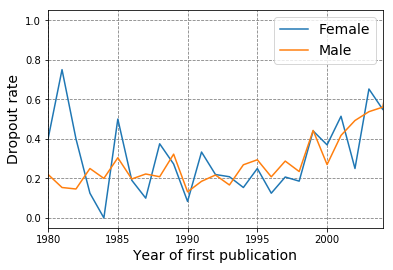

In [106]:
plt.plot(np.arange(year_range[0], year_range[1]),fem_drop/fem_total,label="Female")
plt.plot(np.arange(year_range[0], year_range[1]),male_drop/male_total,label="Male")
plt.xlim(1980,2004)
plt.xlabel("Year of first publication",fontsize=14)
plt.ylabel("Dropout rate",fontsize=14)
plt.legend(fontsize=14)
ax=plt.gca()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.savefig("plots/Dropoutrate.pdf")

In [107]:
Ttest_indResult = stats.ttest_ind(fem_drop[:-10]/fem_total[:-10], male_drop[:-10]/male_total[:-10])
real_t_score=Ttest_indResult.statistic
real_pvalue=Ttest_indResult.pvalue/2
print(real_t_score, real_pvalue)

-0.103201815898 0.459030533531


## Meh stuff

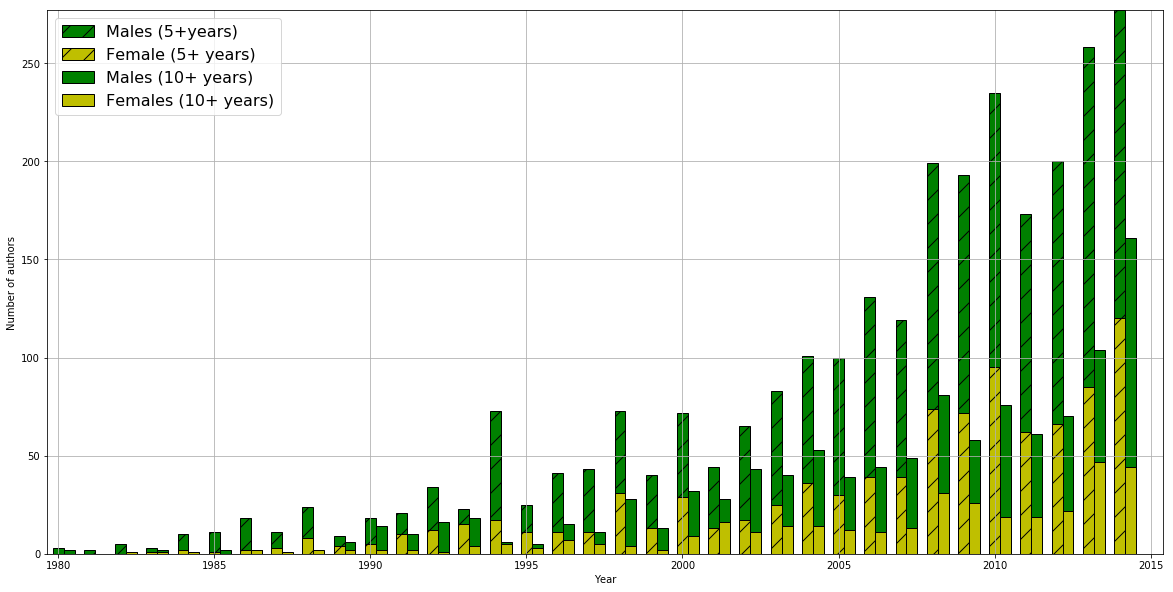

In [6]:
# Setting the positions and width for the bars
pos = list(range(1980,2015)) 
width = 0.35

patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

fig, ax = plt.subplots(figsize=(20,10))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        m,
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='g', 
        edgecolor="black",
        hatch=patterns[0],
        # with label the first value in first_name
        label="Males (5+years)") 

plt.bar(pos, 
        #using df['pre_score'] data,
        f,
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color 
        color='y', 
        edgecolor="black",
        hatch=patterns[0],
        # with label the first value in first_name
        label="Female (5+ years)") 

plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        m2,
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='g', 
        edgecolor="black",
        # with label the second value in first_name
        label="Males (10+ years)")

plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        f2,
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='y', 
        edgecolor="black",
        # with label the second value in first_name
        label="Females (10+ years)")



# Set the y axis label
ax.set_ylabel('Number of authors')

# Set the chart's title
ax.set_xlabel('Year')

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(m+f)] )

# Adding the legend and showing the plot
plt.legend(loc=0, prop={'size': 16})
plt.grid()
plt.savefig("plots/CompareActiveYears.pdf",bbox_inches="tight")
plt.show()

In [7]:
from collections import defaultdict
from itertools import chain
girls = defaultdict(set)
boys = defaultdict(set)
last_publ = defaultdict(int)
first_publ = defaultdict(int)
for i in range(1974,2015):
    year = df[df["year"] == i]
    auths = set(chain.from_iterable(year["authors"]))
    for a in auths:
        if first_publ[a] == 0:
            first_publ[a] = i
            last_publ[a] = i
            continue
       
        if last_publ[a]-first_publ[a] > 5:
            last_publ[a]=i
            first_publ[a]=i
            continue
        if last_publ[a] - first_publ[a] < 4:
            last_publ[a] = i
            continue
        last_publ[a] = i
       
        if a in known_f: 
            girls[i].add(a)
        elif a in known_m: 
            boys[i].add(a)
m = []
f = []
for i in range(1980,2015):
    m.append(len(boys[i]))
    f.append(len(girls[i]))
    

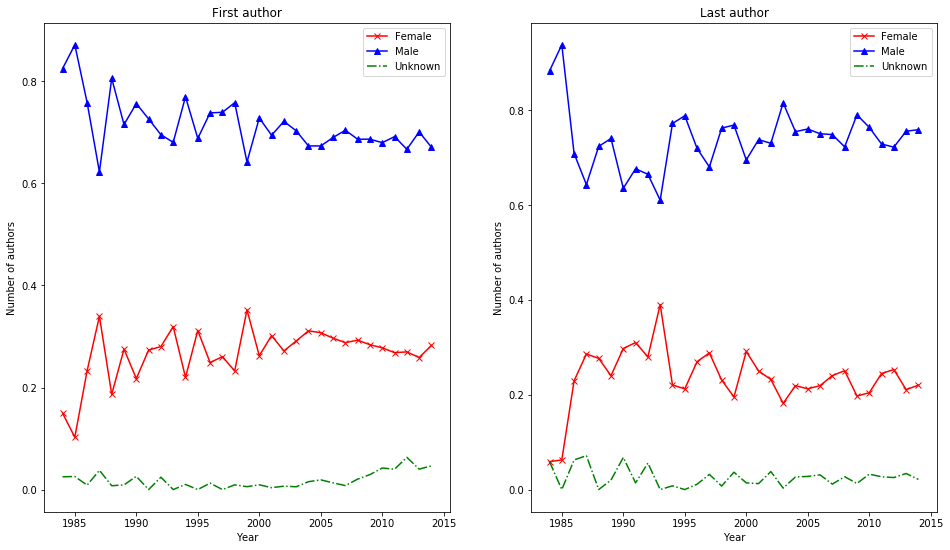

In [15]:
plt.figure()
yrs = []
x = []
y = []
z = []
for i in range(1984,2015):
    year = df[df["year"] == i]
    auths =year["authors"]
    yf=0
    ym=0
    yu=0
    seen = set()
    for b in auths:
        #print(b)
        if len(b)<=1:
            continue
        a = b[0]
        if a in known_f: yf+=1
        elif a in known_m: ym+=1
        else: yu+=1
    yrs.append(i)
    x.append(yf)
    y.append(ym)
    z.append(yu)

t = np.array(x)+np.array(y)+np.array(z)
fig, ax = plt.subplots(1,2,figsize=(16,9))
ax[0].plot(yrs,np.array(x)/t,'-xr',label="Female")
ax[0].plot(yrs,np.array(y)/t,'-^b',label="Male")
ax[0].plot(yrs,np.array(z)/t,'-.g',label="Unknown")
ax[0].set_title("First author")
ax[0].legend()
ax[0].set_ylabel("Number of authors")
ax[0].set_xlabel("Year")
x = np.array(x)/t
z = np.array(z)/t
y = np.array(y)/t
yrs = []
x2 = []
y2 = []
z2 = []
for i in range(1984,2015):
    seen = set()
    year = df[df["year"] == i]
    auths =year["authors"]
    yf=0
    ym=0
    yu=0
    for b in auths:
        #print(b)
        if len(b)<=2:
            continue
        a = b[-1]
        if a in known_f: yf+=1
        elif a in known_m: ym+=1
        else: yu+=1
    yrs.append(i)
    x2.append(yf)
    y2.append(ym)
    z2.append(yu)

t = np.array(x2)+np.array(y2)+np.array(z2)
ax[1].plot(yrs,np.array(x2)/t,'-xr',label="Female")
ax[1].plot(yrs,np.array(y2)/t,'-^b',label="Male")
ax[1].plot(yrs,np.array(z2)/t,'-.g',label="Unknown")
ax[1].set_title("Last author")
ax[1].set_ylabel("Number of authors")
ax[1].set_xlabel("Year")
ax[1].legend()
x2 = np.array(x2)/t
z2 = np.array(z2)/t
y2 = np.array(y2)/t

yrs = []
x3 = []
y3 = []
z3 = []
for i in range(1984,2015):
    year = df[df["year"] == i]
    auths =year["authors"]
    yf=0
    ym=0
    yu=0
    seen = set()
    for b in auths:
        #print(b)
        if len(b)!=1:
            continue
        a = b[0]
        if a in known_f: yf+=1
        elif a in known_m: ym+=1
        else: yu+=1
    yrs.append(i)
    x3.append(yf)
    y3.append(ym)
    z3.append(yu)
    
t = np.array(x3) + np.array(y3) + np.array(z3)
x3 = np.array(x3)/t
z3 = np.array(z3)/t
y3 = np.array(y3)/t

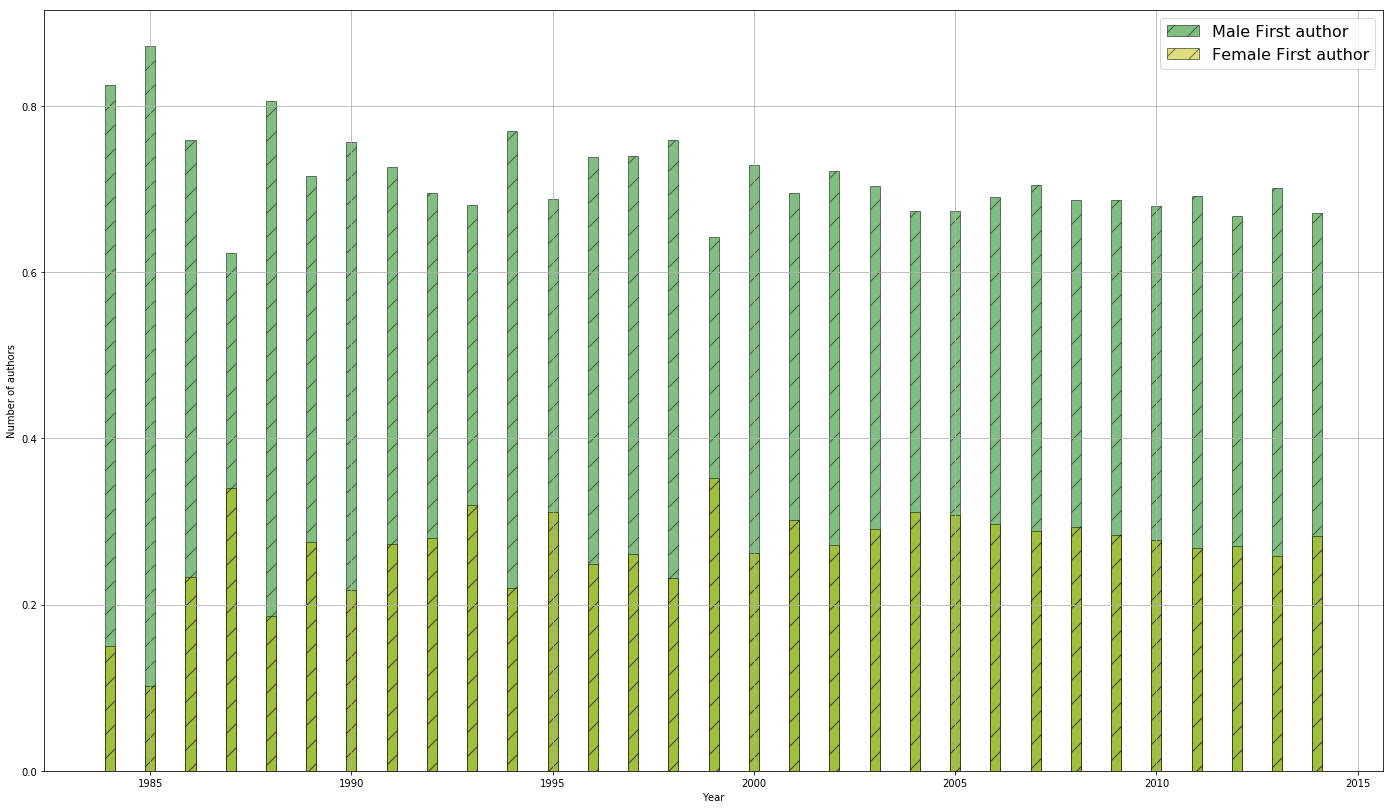

In [18]:
# Setting the positions and width for the bars
pos = list(range(1984,2015)) 
width = 0.25

patterns = [ "/" , "x" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

fig, ax = plt.subplots(figsize=(24,14))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        y,
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='g', 
        edgecolor="black",
        hatch=patterns[0],
        # with label the first value in first_name
        label="Male First author") 

plt.bar(pos, 
        #using df['pre_score'] data,
        x,
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color 
        color='y', 
        edgecolor="black",
        hatch=patterns[0],
        # with label the first value in first_name
        label="Female First author") 

# plt.bar([p + width for p in pos], 
#         #using df['mid_score'] data,
#         y2,
#         # of width
#         width, 
#         # with alpha 0.5
#         alpha=0.5, 
#         # with color
#         color='g', 
#         edgecolor="black",
#         # with label the second value in first_name
#         label="Males Last author")

# plt.bar([p + width for p in pos], 
#         #using df['mid_score'] data,
#         x2,
#         # of width
#         width, 
#         # with alpha 0.5
#         alpha=0.5, 
#         # with color
#         color='y', 
#         edgecolor="black",
#         # with label the second value in first_name
#         label="Females Last author")

# plt.bar([p + width*2 for p in pos], 
#         #using df['mid_score'] data,
#         y3,
#         # of width
#         width, 
#         # with alpha 0.5
#         alpha=0.5, 
#         # with color
#         color='b', 
#         edgecolor="black",
#         hatch=patterns[1],
#         # with label the second value in first_name
#         label="Males Single author")

# plt.bar([p + width*2 for p in pos], 
#         #using df['mid_score'] data,
#         x3,
#         # of width
#         width, 
#         # with alpha 0.5
#         alpha=0.5, 
#         # with color
#         color='r', 
#         edgecolor="black",
#         hatch=patterns[1],
#         # with label the second value in first_name
#         label="Females Single author")



# Set the y axis label
ax.set_ylabel('Number of authors')

# Set the chart's title
ax.set_xlabel('Year')

# Setting the x-axis and y-axis limits
#plt.xlim(min(pos)-width, max(pos)+width*4)
#plt.ylim([0, max(x+y)] )

# Adding the legend and showing the plot
plt.legend(loc=0, prop={'size': 16})
plt.grid()
plt.savefig("plots/CompareFirstLast.pdf")
plt.show()

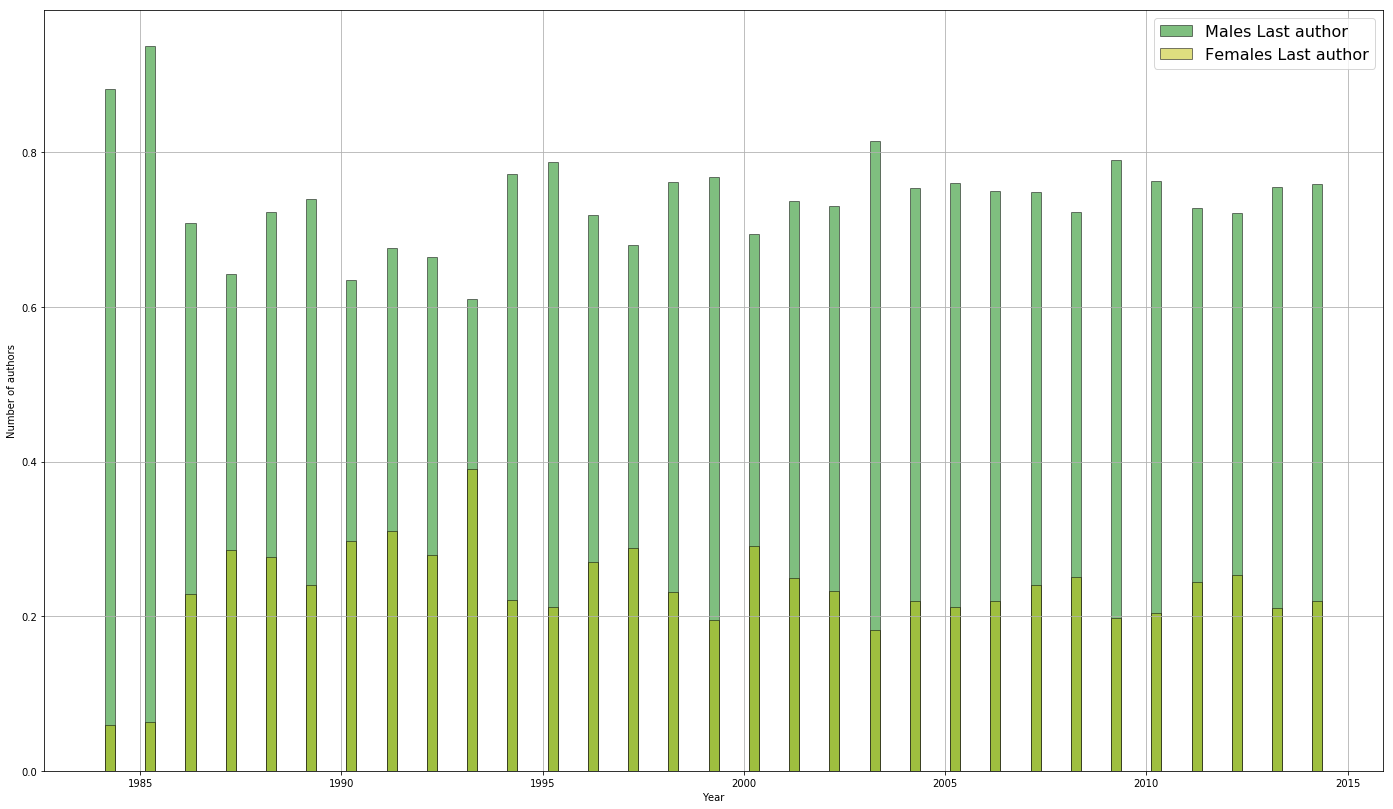

In [19]:
# Setting the positions and width for the bars
pos = list(range(1984,2015)) 
width = 0.25

patterns = [ "/" , "x" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

fig, ax = plt.subplots(figsize=(24,14))

# Create a bar with pre_score data,
# in position pos,
# plt.bar(pos, 
#         #using df['pre_score'] data,
#         y,
#         # of width
#         width, 
#         # with alpha 0.5
#         alpha=0.5, 
#         # with color
#         color='g', 
#         edgecolor="black",
#         hatch=patterns[0],
#         # with label the first value in first_name
#         label="Male First author") 

# plt.bar(pos, 
#         #using df['pre_score'] data,
#         x,
#         # of width
#         width, 
#         # with alpha 0.5
#         alpha=0.5, 
#         # with color 
#         color='y', 
#         edgecolor="black",
#         hatch=patterns[0],
#         # with label the first value in first_name
#         label="Female First author") 

plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        y2,
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='g', 
        edgecolor="black",
        # with label the second value in first_name
        label="Males Last author")

plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        x2,
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='y', 
        edgecolor="black",
        # with label the second value in first_name
        label="Females Last author")

# plt.bar([p + width*2 for p in pos], 
#         #using df['mid_score'] data,
#         y3,
#         # of width
#         width, 
#         # with alpha 0.5
#         alpha=0.5, 
#         # with color
#         color='b', 
#         edgecolor="black",
#         hatch=patterns[1],
#         # with label the second value in first_name
#         label="Males Single author")

# plt.bar([p + width*2 for p in pos], 
#         #using df['mid_score'] data,
#         x3,
#         # of width
#         width, 
#         # with alpha 0.5
#         alpha=0.5, 
#         # with color
#         color='r', 
#         edgecolor="black",
#         hatch=patterns[1],
#         # with label the second value in first_name
#         label="Females Single author")



# Set the y axis label
ax.set_ylabel('Number of authors')

# Set the chart's title
ax.set_xlabel('Year')

# Setting the x-axis and y-axis limits
#plt.xlim(min(pos)-width, max(pos)+width*4)
#plt.ylim([0, max(x+y)] )

# Adding the legend and showing the plot
plt.legend(loc=0, prop={'size': 16})
plt.grid()
plt.savefig("plots/CompareFirstLast.pdf")
plt.show()